In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                             classification_report, confusion_matrix,
                             RocCurveDisplay)
from sklearn.calibration import calibration_curve
import shap
import joblib

In [57]:
df = pd.read_csv("maternal_data.csv")

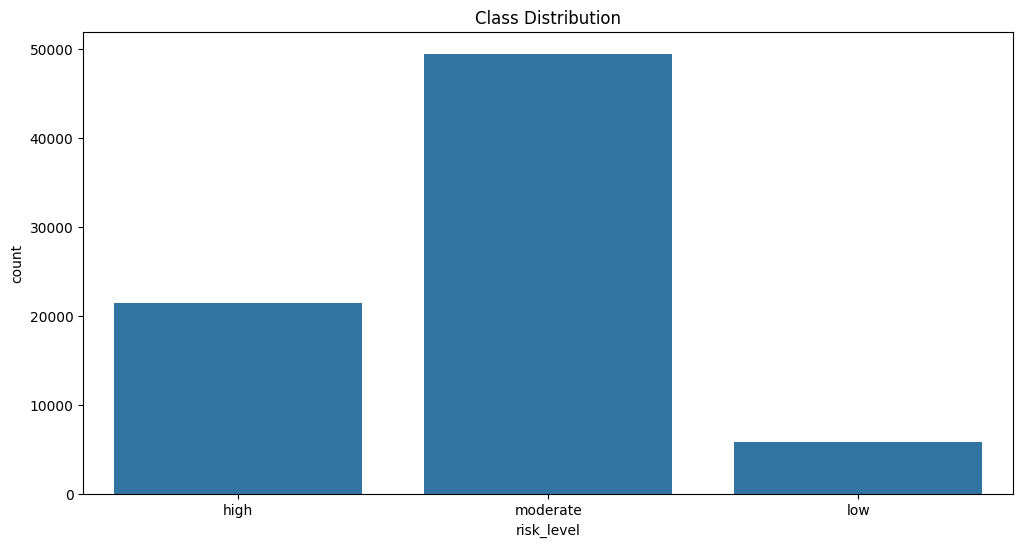

In [58]:
# Visualize class distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='risk_level', data=df)
plt.title('Class Distribution')
plt.show()

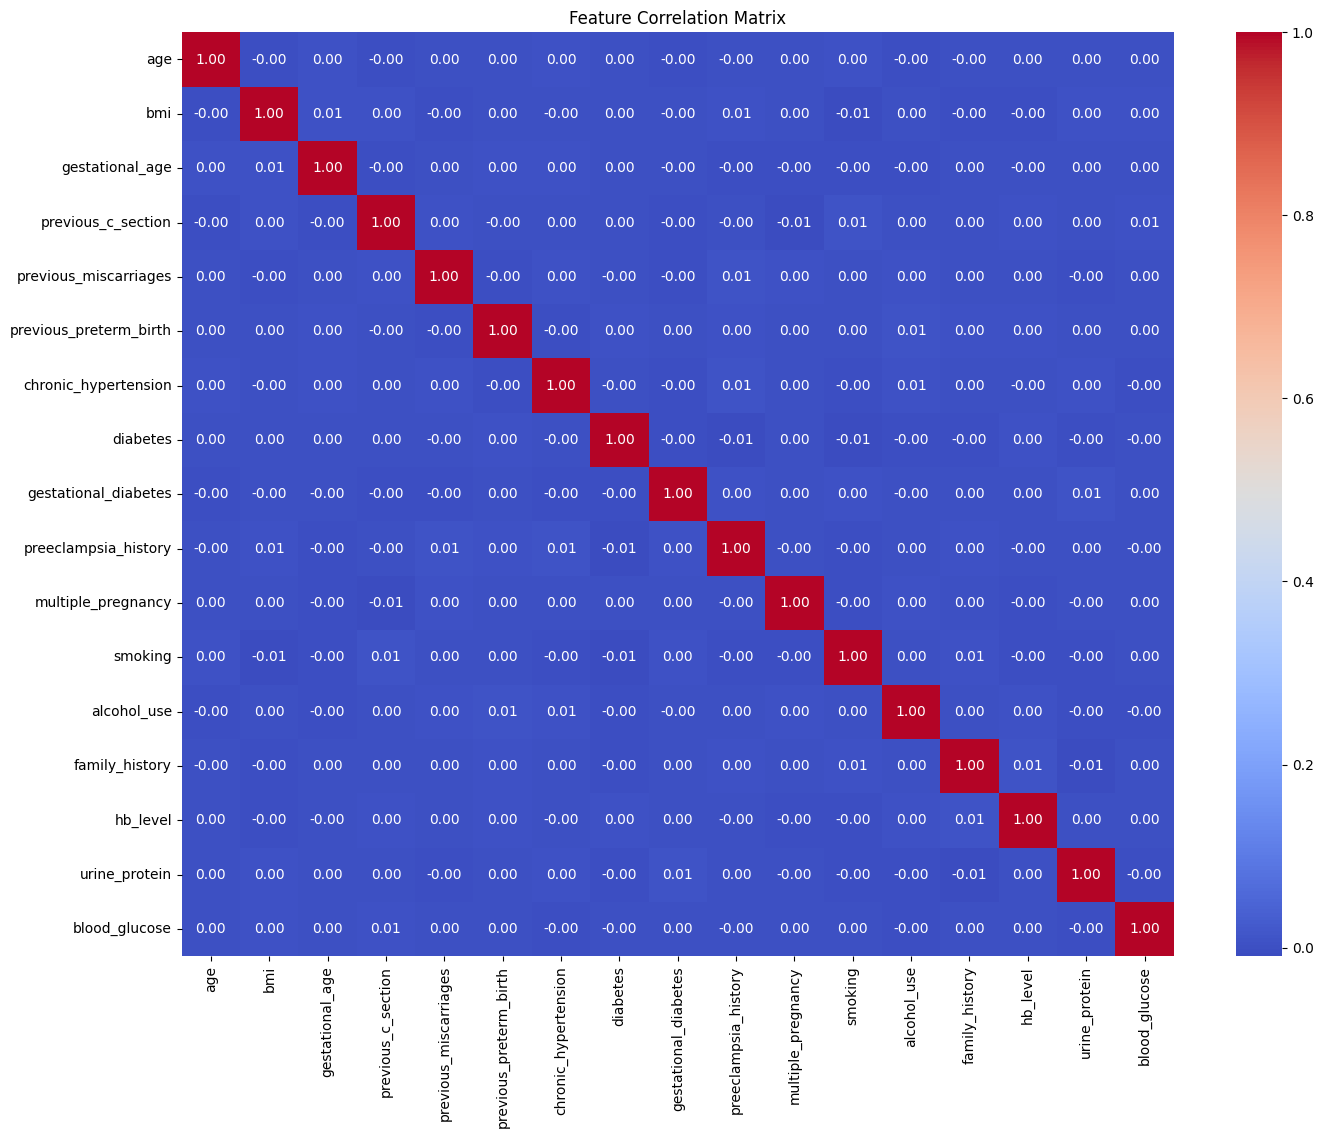

In [59]:
# Correlation matrix (numeric only)
plt.figure(figsize=(16, 12))
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

In [60]:
# Encode target
le = LabelEncoder()
df['risk_level'] = le.fit_transform(df['risk_level'])


In [61]:
# Split data
X = df.drop('risk_level', axis=1)
y = df['risk_level']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


In [62]:
# Split data
X = df.drop('risk_level', axis=1)
y = df['risk_level']

# --- FIX: Split blood_pressure BEFORE train_test_split ---
if 'blood_pressure' in X.columns:
    X[['systolic', 'diastolic']] = X['blood_pressure'].str.split('/', expand=True).astype(int)
    X = X.drop('blood_pressure', axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [63]:
# Define models and param grids
xgb = XGBClassifier(objective='multi:softmax')
rf = RandomForestClassifier(class_weight='balanced')
mlp = MLPClassifier(max_iter=1000)
meta_model = MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000)

param_grids = {
    'xgb': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2]
    },
    'rf': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20]
    },
    'mlp': {
        'hidden_layer_sizes': [(100,), (50,50)],
        'alpha': [0.0001, 0.001]
    }
}


Tuning XGB...


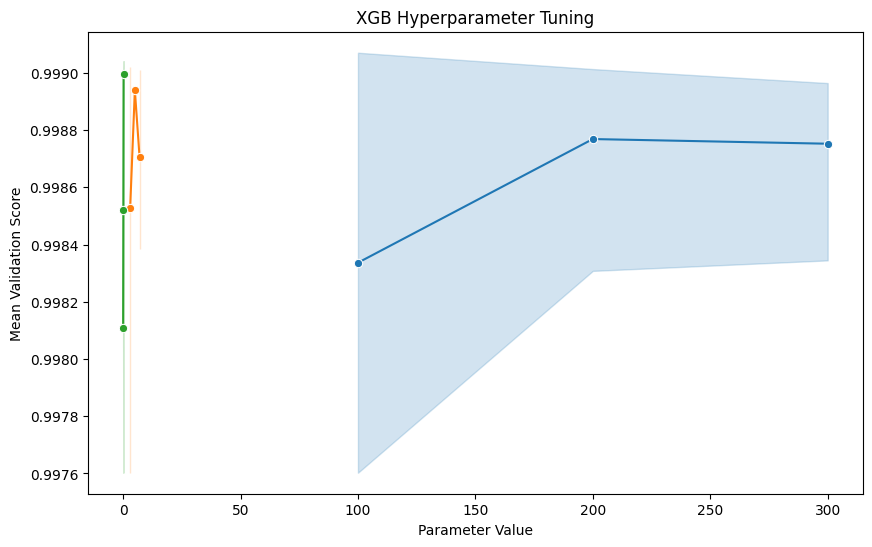


Tuning RF...


c:\Users\abusa\Desktop\Project\maternal-risk-app\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


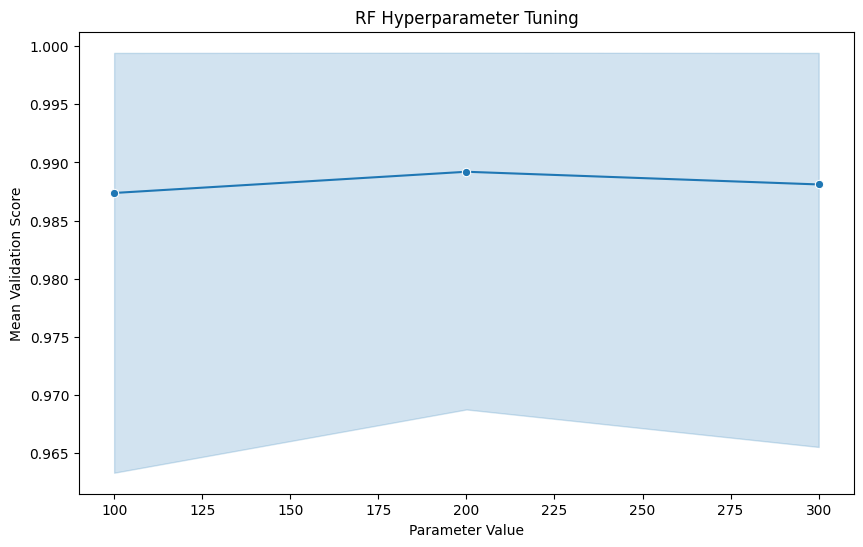


Tuning MLP...


c:\Users\abusa\Desktop\Project\maternal-risk-app\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


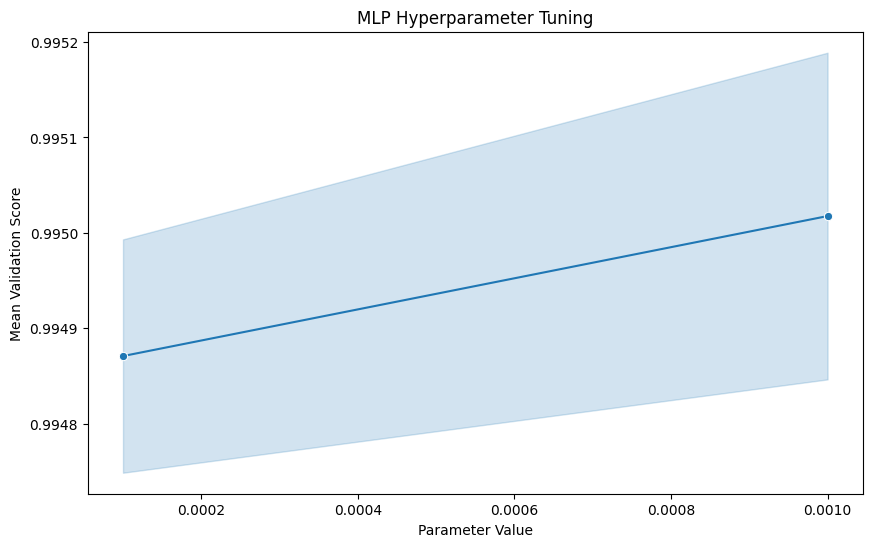

In [64]:
# Hyperparameter tuning
best_models = {}
for name, model in [('xgb', xgb), ('rf', rf), ('mlp', mlp)]:
    print(f"\nTuning {name.upper()}...")
    search = RandomizedSearchCV(
        model, param_grids[name], n_iter=10, cv=3, n_jobs=-1
    )
    search.fit(X_train_scaled, y_train)
    best_models[name] = search.best_estimator_
    
    # Plot validation curve
    results = pd.DataFrame(search.cv_results_)
    plt.figure(figsize=(10, 6))
    for param in param_grids[name].keys():
        if results[f'param_{param}'].dtype == 'object': continue
        sns.lineplot(x=f'param_{param}', y='mean_test_score', 
                     data=results, marker='o')
    plt.title(f'{name.upper()} Hyperparameter Tuning')
    plt.xlabel('Parameter Value')
    plt.ylabel('Mean Validation Score')
    plt.show()

In [65]:

# Define stacking model using best estimators
stack_model = StackingClassifier(
    estimators=[
        ('xgb', best_models['xgb']),
        ('rf', best_models['rf']),
        ('mlp', best_models['mlp'])
    ],
    final_estimator=meta_model,
    stack_method='predict_proba'
)

In [66]:
# Fit stacking model
stack_model.fit(X_train_scaled, y_train)


StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None,
                                              feature_weights=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_const...
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None, ...)),
                               ('rf',
                                RandomForestClassifier(class_weight='balanced',
                                                       n_estimators=200)),
                               ('mlp',
                                MLPClassifier(alpha=0.001, max_iter=1000))],
                   final_estimator=MLPClassifier(hidden_layer_sizes=(50,),
                                                 max_iter=1000),
                   stack_method='predict_proba')

In [67]:
# Evaluation function
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix(y_test, y_pred), 
                annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, 
                yticklabels=le.classes_)
    plt.title('Confusion Matrix')
    plt.show()
    
    fig, ax = plt.subplots(figsize=(10, 8))
    for i, class_name in enumerate(le.classes_):
        RocCurveDisplay.from_predictions(
            (y_test == i).astype(int),
            y_proba[:, i],
            name=f"{class_name} vs Rest",
            ax=ax
        )
    plt.title('ROC Curves')
    plt.show()
    
    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred, average='weighted'),
        'roc_auc': roc_auc_score(y_test, y_proba, multi_class='ovr')
    }


              precision    recall  f1-score   support

        high       1.00      1.00      1.00      4275
         low       1.00      1.00      1.00      1163
    moderate       1.00      1.00      1.00      9891

    accuracy                           1.00     15329
   macro avg       1.00      1.00      1.00     15329
weighted avg       1.00      1.00      1.00     15329



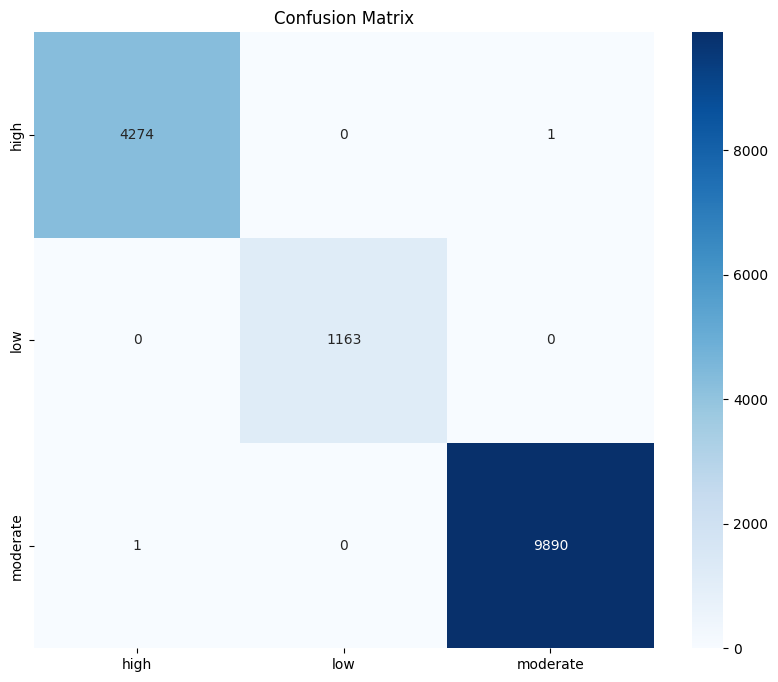

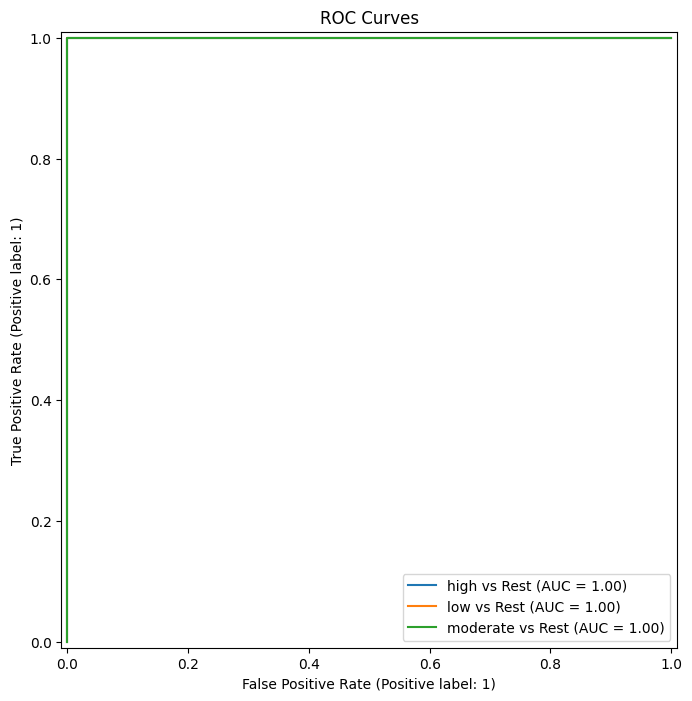

In [68]:
metrics = evaluate_model(stack_model, X_test_scaled, y_test)


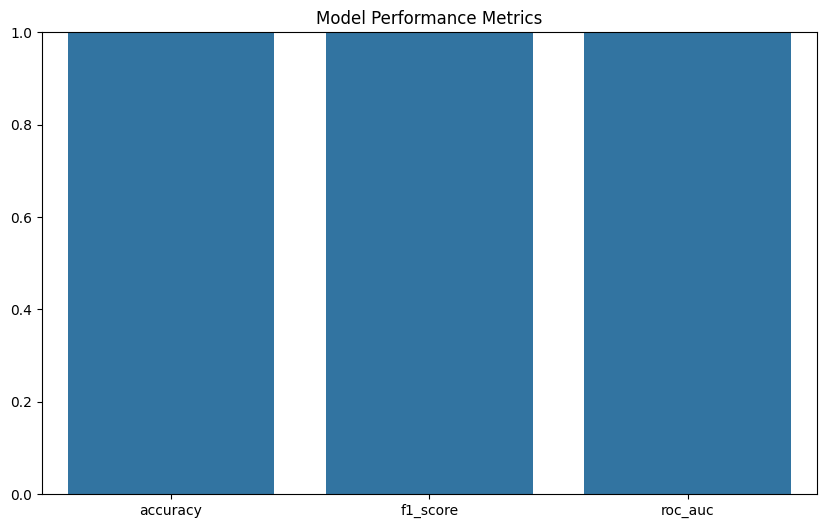

In [69]:
plt.figure(figsize=(10, 6))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()))
plt.title('Model Performance Metrics')
plt.ylim(0, 1)
plt.show()

100%|██████████| 10/10 [00:23<00:00,  2.38s/it]


<Figure size 640x480 with 0 Axes>

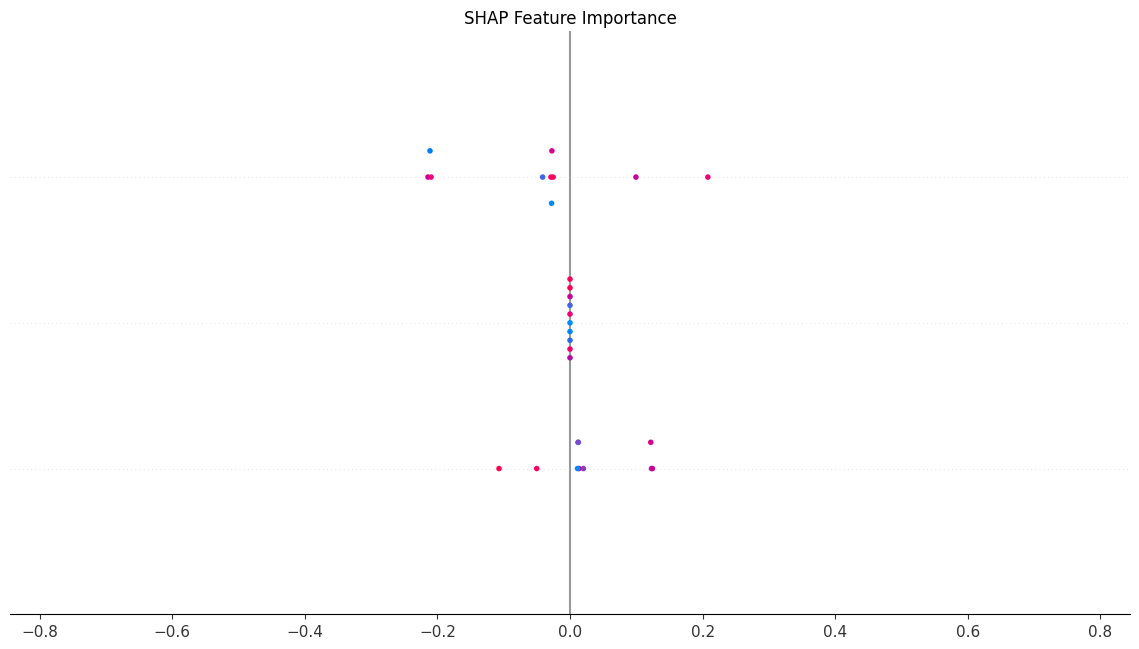

In [70]:
# SHAP analysis
explainer = shap.KernelExplainer(stack_model.predict_proba, X_train_scaled[:100])
shap_values = explainer.shap_values(X_test_scaled[:10])
shap.summary_plot(shap_values, X_test_scaled[:10], 
                 feature_names=X.columns, 
                 class_names=le.classes_,
                 show=False)
plt.title('SHAP Feature Importance')
plt.tight_layout()
plt.show()

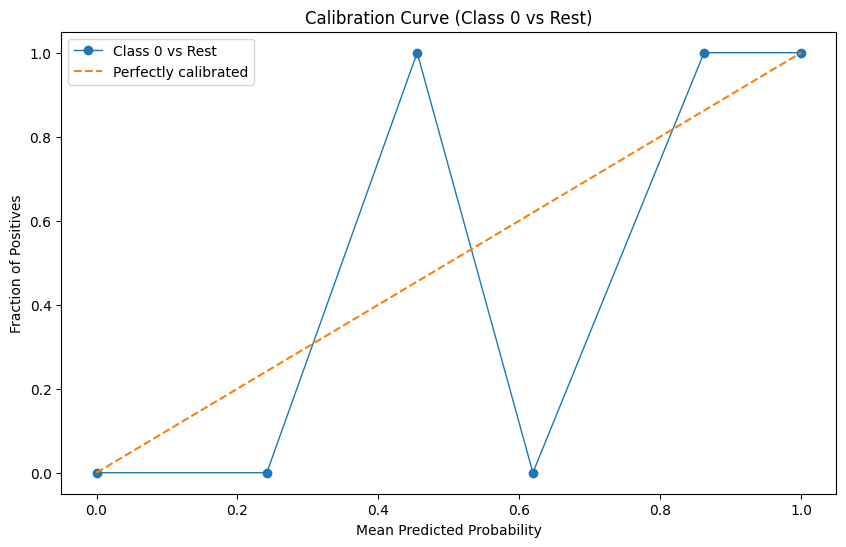

In [72]:
from sklearn.calibration import calibration_curve

class_idx = 0  # Change to 1 or 2 for other classes
y_true_bin = (y_test == class_idx).astype(int)
y_proba_bin = stack_model.predict_proba(X_test_scaled)[:, class_idx]

prob_true, prob_pred = calibration_curve(y_true_bin, y_proba_bin, n_bins=10)

plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label=f'Class {class_idx} vs Rest')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.title(f'Calibration Curve (Class {class_idx} vs Rest)')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.show()

In [73]:
# Save artifacts
joblib.dump(stack_model, 'maternal_risk_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(le, 'label_encoder.pkl')
print("Model artifacts saved successfully!")

Model artifacts saved successfully!
